ModuleNotFoundError: No module named 'brian2'

Done in 3.8429677486419678


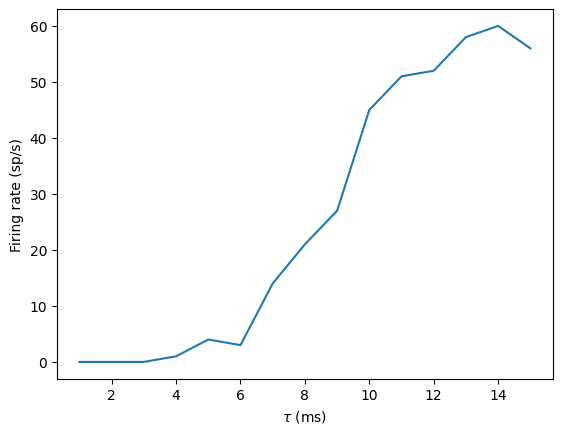

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
from time import time

b2.set_device('cpp_standalone', build_on_run=False)

class SimWrapper:
    def __init__(self):
        self.net = b2.Network()
        P = b2.PoissonGroup(num_inputs, rates=input_rate)
        eqs = """
            dv/dt = -v/tau : 1
            tau : second (constant)
            """
        G = b2.NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler', name='neuron')
        S = b2.Synapses(P, G, on_pre='v += weight')
        S.connect()
        M = b2.SpikeMonitor(G, name='spike_monitor')
        self.net.add([P, G, S, M])

        self.net.run(1000 * b2.ms)

        self.device = b2.get_device()
        self.device.build(run=False, directory=None)  # compile the code, but don't run it yet

    def do_run(self, tau_i):
        # Workaround to set the device globally in this context
        from brian2.devices import device_module
        device_module.active_device = self.device

        result_dir = f'result_{tau_i}'
        self.device.run(run_args={self.net['neuron'].tau: tau_i},
                        results_directory=result_dir)
        return self.net["spike_monitor"].num_spikes/ b2.second


if __name__ == "__main__":
    start_time = time()
    num_inputs = 100
    input_rate = 10 * b2.Hz
    weight = 0.1

    npoints = 15
    tau_range = np.linspace(1, 15, npoints) * b2.ms

    sim = SimWrapper()

    from multiprocessing import Pool
    with Pool(npoints) as pool:
        output_rates = pool.map(sim.do_run, tau_range)

    print(f"Done in {time() - start_time}")

    plt.plot(tau_range/b2.ms, output_rates)
    plt.xlabel(r"$\tau$ (ms)")
    plt.ylabel("Firing rate (sp/s)")
    plt.show()

In [ ]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils


import brian2cuda

from brian2 import prefs
from brian2 import set_device
from brian2.devices import device_module



set_device("cuda_standalone", directory='project', build_on_run=False)

device = b2.get_device()

#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)




# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iinh - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iinh : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc2 : amp  # Synaptic input
I_tot = Iexc + Iexc2 + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
Iexc_post = w * X_pre : amp (summed)
'''

syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance
Iexc2_post = w * X_pre : amp (summed)
'''

syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance
Iinh_post = w * X_pre : amp (summed)
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups




def make_bottom_up_connections(R, E_0, E_1):
    S_p = Synapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect(condition='i == j')
    S_p.w = 'w_init'

    S_m = Synapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect(condition='i == j')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    S_p = Synapses(R, E_1, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect()
    S_p.w = 'rand() * w_init'

    S_m = Synapses(R, E_0, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect()
    S_m.w = 'rand() * w_init'

    return S_p, S_m

def make_gist_connections(Rs, G):
    S_gist_input = Synapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = Synapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output

def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/10

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    S_o = Synapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os, S_o

def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])
        connections[f"bottom_up_{i}"] = [S_p, S_m]

        if i != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i])
            connections[f"top_down_{i}"] = [S_p_td, S_m_td]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = Synapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]

    return Rs, Es_0, Es_1, G, Os, S_o_internal, connections

def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor

def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped

def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
dims = [19*19, 250, 125, 64]
num_classes_per_layer = 4
max_depth = 3

Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 200
N = 19
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 500
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])

@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X

@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        
        
        
        
            
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                S_p.w[i_idx, j_idx] += lr * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens
                S_m.w[i_idx, j_idx] += lr * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] * siemens
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0
    
    
    
    external_syn = connections["output_external"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            external_syn.w[i_idx, j_idx] += lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
            
            
     
            


# Extract all synapses and objects for the network
all_synapses = []
all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
all_synapses.append(external_syn)

#monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
#spike_monitor = SpikeMonitor(Rs[0])

s = 0


monitor_o = StateMonitor(Os, ['v', 'I_tot', 'X'], record=True)
spike_mon_o = SpikeMonitor(Os, record = True)


net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,        
    monitor_o, spike_mon_o,         # <-- Add these
    debug, update_sums, apply_weight_update
)




all_batch_rates = []
output_spikes = []

s = 0
stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))
net.stimulus_indexes = stimulus_indexes
net.output_stimuli   = output_stimuli
net.input_stimuli    = input_stimuli



run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)


# device.build(directory='project', run = False)



class SimWrapper:
    def __init__(self, net):
        self.net = net
        self.device = b2.get_device()
        self.device.build(run=False, directory="project")  # compile the code, but don't run it yet

    def do_run(self, net, tau_i):

        self.net = net
        
        # Workaround to set the device globally in this context

        device_module.active_device = self.device

        result_dir = f'result_{tau_i}'
        
    
      
        self.device.run(results_directory=result_dir)
        
        return self.net

sim = SimWrapper(net)

# device.build(directory='cuda_project', compile=True, run=True)


INFO       CUDA installation directory detected via location of `nvcc` binary: /usr/local/cuda [brian2cuda.utils.gputools]


In [ ]:
num_epochs = 3

for i in range(num_epochs):
    print(f"Starting epoch {i}.")
    start = time.time()
    
    net = sim.do_run(net, i)
    
    duration = time.time() - start

    if i == 0:
        total_estimated_duration = duration * num_epochs
        estimated_finish = datetime.datetime.now() + datetime.timedelta(seconds=total_estimated_duration)
        print("Estimated finish time:", estimated_finish.strftime("%H:%M:%S"))


    print(f"Epoch {i} took {duration:.2f} seconds.\n")

In [3]:
start = time.time()
net = sim.do_run(net, 1)
duration = time.time() - start

INFO: _init_arrays() took 0.115917s
INFO: synapses creation took 0.000209s
INFO: synapses creation took 0.000256s
INFO: synapses_1 creation took 0.000112s
INFO _run_kernel_synapses_1_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	8 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	10872 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO: synapses_2 creation took 0.000169s
INFO _run_kernel_synapses_2_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	8 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	10872 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO: synapses_3 creation took 0.000158s
INFO _run_kernel_synapses_3_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	10 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	

In [4]:
duration

418.12955617904663

In [ ]:
net = sim.do_run(net, 2)

INFO: _init_arrays() took 0.115734s
INFO: synapses creation took 0.000213s
INFO: synapses creation took 0.000249s
INFO: synapses_1 creation took 0.000112s
INFO _run_kernel_synapses_1_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	8 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	10872 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO: synapses_2 creation took 0.000108s
INFO _run_kernel_synapses_2_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	8 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	10872 bytes user-allocated constant memory
	1.000 theoretical occupancy
INFO: synapses_3 creation took 0.000121s
INFO _run_kernel_synapses_3_group_variable_set_conditional_codeobject
	1 blocks
	1024 threads
	10 registers per thread
	0 bytes statically-allocated shared memory per block
	0 bytes local memory per thread
	

In [18]:
new_states.keys()

dict_keys(['synapses', 'synapses_1', 'synapses_10', 'synapses_11', 'synapses_12', 'synapses_13', 'synapses_14', 'synapses_15', 'synapses_2', 'synapses_3', 'synapses_4', 'synapses_5', 'synapses_6', 'synapses_7', 'synapses_8', 'synapses_9', 'synapses_10_pre', 'synapses_11_pre', 'synapses_12_pre', 'synapses_13_pre', 'synapses_14_pre', 'synapses_15_pre', 'synapses_1_pre', 'synapses_2_pre', 'synapses_3_pre', 'synapses_4_pre', 'synapses_5_pre', 'synapses_6_pre', 'synapses_7_pre', 'synapses_8_pre', 'synapses_9_pre', 'synapses_pre'])

In [19]:
s = new_states["synapses"]

In [22]:
s.items()

dict_items([('t', 100. * second), ('dt', 100. * usecond), ('t_in_timesteps', array(1000000)), ('N_incoming', array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9,

Text(0.5, 1.0, 'Firing Rate')

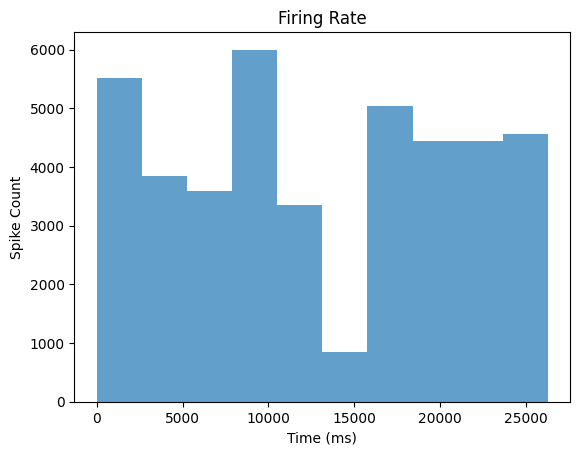

In [7]:
plt.hist(spike_mon_o["t"]/ ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate')


In [6]:
import brian2 as b2
from time import time
import brian2cuda

b2.set_device('cuda_standalone', build_on_run=False)

dev = b2.get_device()

import inspect 

signature = inspect.signature(dev.run)

print(signature)

(directory=None, results_directory=None, with_output=True, run_args=None)


In [ ]:
spike_mon_o = monitor

In [12]:
from collections import defaultdict

# Organize spikes by neuron
spike_times_by_neuron = defaultdict(list)

# Loop through the recorded spikes
for neuron_idx, spike_time in zip(spike_mon_o["i"], spike_mon_o["t"]):
    spike_times_by_neuron[neuron_idx].append(spike_time)



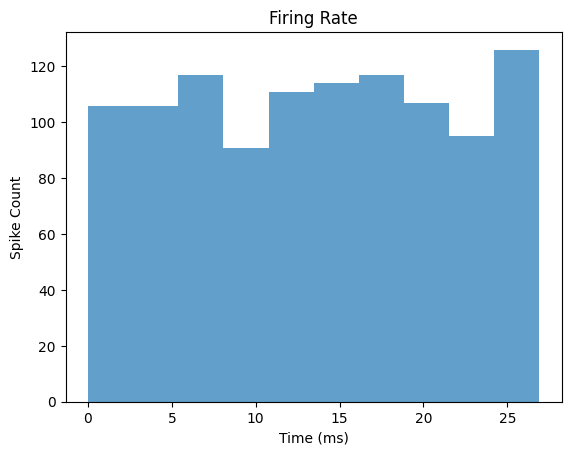

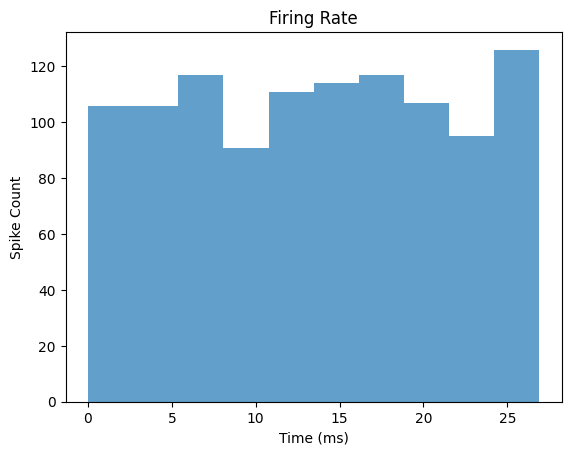

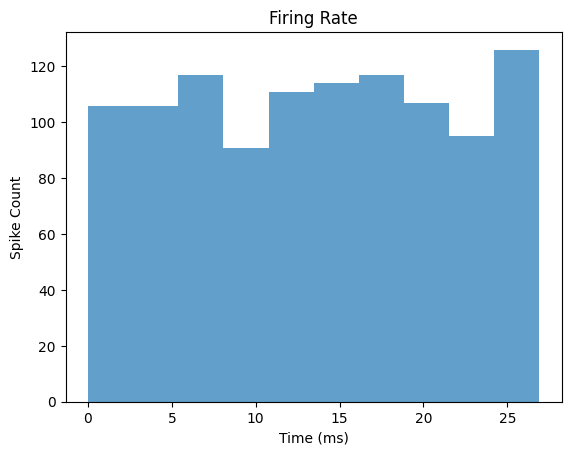

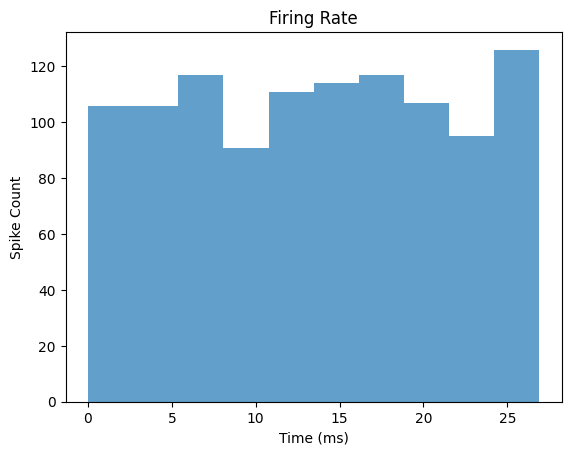

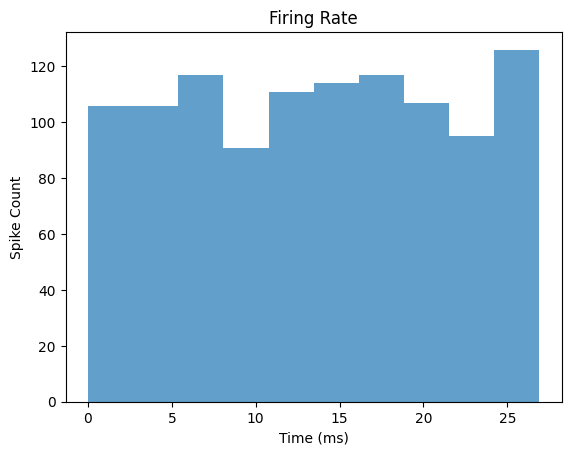

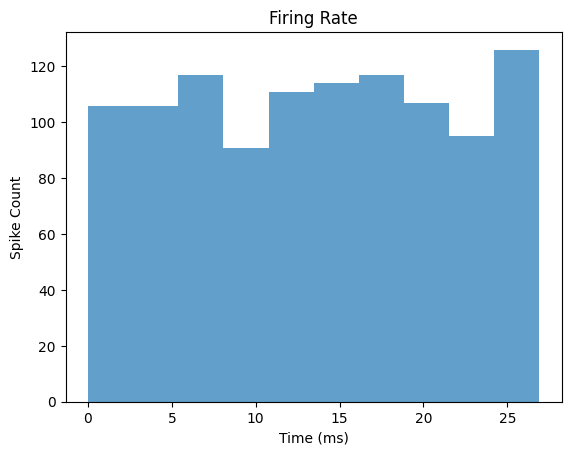

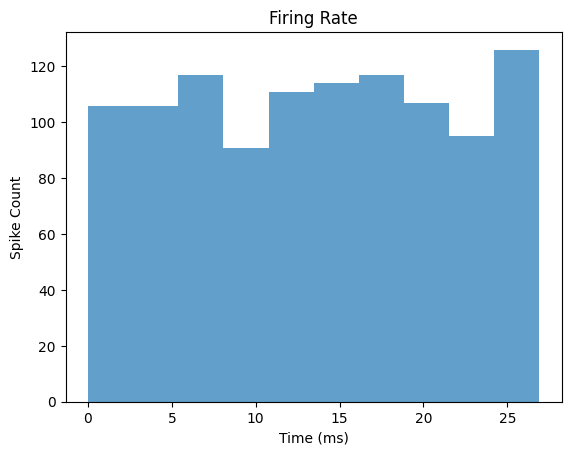

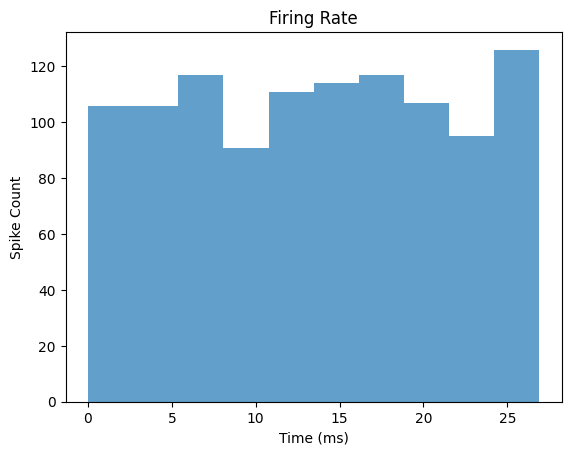

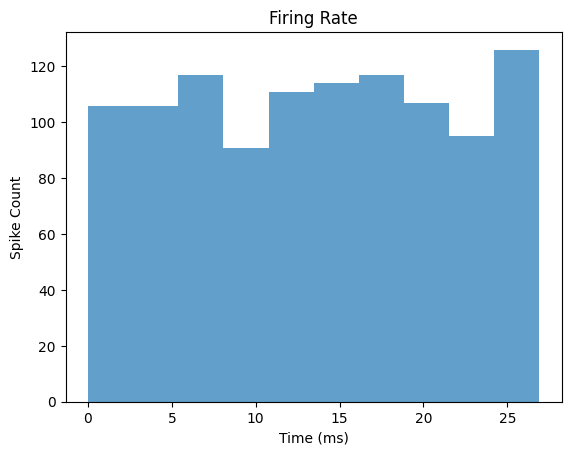

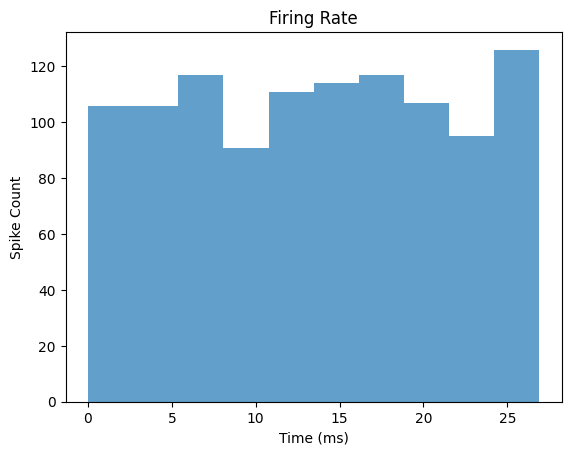

In [13]:
for n in spike_times_by_neuron.keys():
    plt.hist(spike_times_by_neuron[n], bins=10, alpha=0.7)
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike Count')
    plt.title('Firing Rate')
    plt.show()

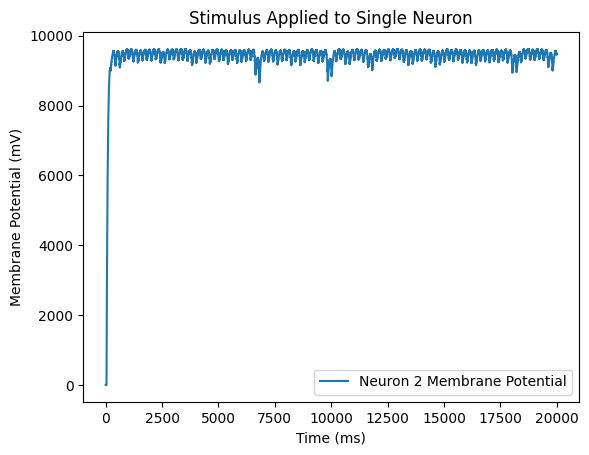

In [3]:
plt.plot(monitor_o.t / ms, monitor_o.X[1] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

In [5]:
spike_mon_o[7].t

TypeError: 'SpikeMonitor' object is not subscriptable

In [4]:
for x in monitor_o.X:
    print(x)

[0.         0.         0.         ... 9.46286278 9.46247197 9.46204487] V
[0.         0.         0.         ... 9.46286278 9.46247197 9.46204487] V
[0.         0.         0.         ... 9.46286278 9.46247197 9.46204487] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 9.46305365 9.46266246 9.46223498] V
[0.         0.         0.02       ... 

In [2]:
import os
import torch
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils


import brian2cuda

from brian2 import prefs
from brian2 import set_device




set_device("cuda_standalone", build_on_run=False)

#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)




# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iinh - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iinh : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc2 : amp  # Synaptic input
I_tot = Iexc + Iexc2 + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
Iexc_post = w * X_pre : amp (summed)
'''

syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance
Iexc2_post = w * X_pre : amp (summed)
'''

syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance
Iinh_post = w * X_pre : amp (summed)
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups




def make_bottom_up_connections(R, E_0, E_1):
    S_p = Synapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect(condition='i == j')
    S_p.w = 'w_init'

    S_m = Synapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect(condition='i == j')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    S_p = Synapses(R, E_1, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_p.connect()
    S_p.w = 'rand() * w_init'

    S_m = Synapses(R, E_0, model=syn_eqs_inh, on_pre='Y_post = 1*volt')
    S_m.connect()
    S_m.w = 'rand() * w_init'

    return S_p, S_m

def make_gist_connections(Rs, G):
    S_gist_input = Synapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = Synapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output

def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/10

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    S_o = Synapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os, S_o

def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])
        connections[f"bottom_up_{i}"] = [S_p, S_m]

        if i != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i])
            connections[f"top_down_{i}"] = [S_p_td, S_m_td]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = Synapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]

    return Rs, Es_0, Es_1, G, Os, S_o_internal, connections

def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor

def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped

def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
dims = [20, 10, 7, 5]
num_classes_per_layer = 3
max_depth = 3

Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 5
N = 15
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 100
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])

@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X

@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        
        
        
        
            
        for i_idx in range(Es_0[n].N):
            for j_idx in range(Rs[n+1].N):
                
                S_p.w[i_idx, j_idx] += lr * Es_0[n].batch_sum_X[i_idx] * Rs[n+1].batch_sum_X[j_idx] * siemens
                S_m.w[i_idx, j_idx] += lr * Es_1[n].batch_sum_X[i_idx] * Rs[n+1].batch_sum_X[j_idx] * siemens
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0
    
    
    
    external_syn = connections["output_external"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            external_syn.w[i_idx, j_idx] += lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            



# Extract all synapses and objects for the network
all_synapses = []
all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
all_synapses.append(external_syn)

monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(Rs[0])

s = 0

monitor_o = StateMonitor(Os, ['v', 'I_tot', 'X'], record=True)
spike_mon_o = SpikeMonitor(Os, record = True)



net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,
    monitor, spike_monitor,         # The monitors for Rs[0]
    monitor_o, spike_mon_o,         # <-- Add these
    debug, update_sums, apply_weight_update, log_spikes
)




all_batch_rates = []
output_spikes = []
for s, (stimulus_indexes, output_stimuli, input_stimuli) in enumerate(dl):
    print(f"batch n.{s}")

      # 1) Reset the spike count to 0 if you want each batch to be measured independently


    # 2) Set references for the network operations

    # Run the network
    # (batch_size + batch_size*num_pause_blocks)*100*ms

    run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
    net.run(run_time)

    '''
    net.remove(monitor_o)  # Optional, to explicitly clean up
    spike_mon_o = SpikeMonitor(Os)  # Recreate the monitor
    net.add(spike_mon_o)  # Add the new monitor to the network

    net.remove(spike_mon_o)  # Optional, to explicitly clean up
    spike_mon_o = SpikeMonitor(Os)  # Recreate the monitor
    net.add(spike_mon_o)  # Add the new monitor to the network
    #net.stop()
    '''
device.build(directory='cuda_project2', compile=True, run=True)


batch n.0
batch n.1


INFO       Compiling device code for GPU 0 (Tesla V100-SXM2-16GB) [brian2cuda.utils.gputools]
INFO       Compiling device code for compute capability 7.0 (compiler flags: ['-arch=sm_70']) [brian2cuda.device]
INFO       Using the following preferences for CUDA standalone: [brian2cuda.device]
INFO       	devices.cuda_standalone.SM_multiplier = 1 [brian2cuda.device]
INFO       	devices.cuda_standalone.parallel_blocks = 1 [brian2cuda.device]
INFO       	devices.cuda_standalone.launch_bounds = False [brian2cuda.device]
INFO       	devices.cuda_standalone.syn_launch_bounds = False [brian2cuda.device]
INFO       	devices.cuda_standalone.calc_occupancy = True [brian2cuda.device]
INFO       	devices.cuda_standalone.extra_threshold_kernel = True [brian2cuda.device]
INFO       	devices.cuda_standalone.random_number_generator_type = CURAND_RNG_PSEUDO_DEFAULT [brian2cuda.device]
INFO       	devices.cuda_standalone.random_number_generator_ordering = False [brian2cuda.device]
INFO       	devices.cuda

RuntimeError: Project compilation failed (error code: 512). Consider running with "clean=True" to force a complete rebuild.

In [3]:
from brian2.utils.logger import get_log
print(get_log('brian2.cuda_standalone'))

ImportError: cannot import name 'get_log' from 'brian2.utils.logger' (/usr/local/lib/python3.10/dist-packages/brian2/utils/logger.py)

In [ ]:
spike_data = spike_mon.get_states()

In [ ]:
output_spikes

In [ ]:
# Suppose you want to plot the last batch's firing rates
all_batch_rates = [spike_monitor_os.count/run_time for spike_monitor_os in output_monitors]

for batch_rates in all_batch_rates:

  plt.figure(figsize=(10, 5))
  plt.bar(range(Os.N), batch_rates)
  plt.xlabel("Os Neuron Index")
  plt.ylabel("Firing rate (Hz)")
  plt.title("Average firing rate of Os neurons (last batch)")
  plt.show()


In [ ]:
from pprint import pprint

pprint(vars(spike_monitor))

In [ ]:

# spike_monitor = SpikeMonitor(Os)


# Plot membrane potential

plt.figure(figsize=(10, 4))



# Firing rate plot
plt.subplot(1, 1, 1)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()




In [ ]:
def training_phase_1(network, dl):

  for label_input, curve_input in dl:
    ...

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Input')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Input')

plt.tight_layout()
plt.show()



## Other

In [ ]:
network = Network(
    *Rs,        # Unpack the list of NeuronGroups
    *Es_0,      # Unpack the list of NeuronGroups
    *Es_1,      # Unpack the list of NeuronGroups
    G,          # Single NeuronGroup is fine
    Os,         # Single NeuronGroup is fine
    connections["output_internal"],   # Single Synapses object is fine
    connections["gist_input"],        # Single Synapses object is fine
    *connections["gist_output"],      # Unpack the list of Synapses
    *connections["output_external"],  # Unpack the list of Synapses
    spike_monitor,
    monitor,
    debug,
    update_sums,
    apply_weight_update
)


In [ ]:
eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  : amp
'''


neuron = make_groups([1], eqs = eqs_neuron)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c] for c in np.ones(1)*0.8]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(neuron)

run(1 * second)

# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''

In [ ]:
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y_post = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Input current
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = input_stimuli(t)  : amp
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Synaptic input (summed)
I_tot = I + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

syn_eqs_inh= '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation

In [ ]:
# Update logic
@network_operation(dt = batch_size * msec_step * ms)
def update_sums( ):

    current_idx = int(defaultclock.t / msec_step*ms)

    if stimulus_indexes.values[current_idx] == 1:


        for n in range(len(Rs)-1):

            for i in range(len(Rs[n])):

                '''
                Rs[n].batch_sum_X[i] += Rs[n].X_[i]

                Es_0[n].batch_sum_X[i] += Es_0[n].X_[i]

                Es_1[n].batch_sum_X[i] += Es_1[n].X_[i]
                '''

                Rs[n].batch_sum_X += Rs[n].X_
                Es_0[n].batch_sum_X += Es_0[n].X_
                Es_1[n].batch_sum_X += Es_1[n].X_


@network_operation( dt = batch_size * msec_step * ms )
def apply_weight_update():

    print("Applying weight update")

    for n in range(len(Rs)-1):
        print("n: ", n)

        for i in range(len(Rs[n])):
            print("i: ", i)
            for j in range(len(Es_0[n])):
                print("j: ", j)


                S_p, S_m = connections[f"top_down_{n}"]

                S_p.w[i,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n].batch_sum_X[i] * siemens

                S_m.w[i,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n].batch_sum_X[i]  * siemens

                Rs[n].batch_sum_X[i] = 0

                Es_0[n].batch_sum_X[i]= 0

                Es_1[n].batch_sum_X[i] = 0



for stimulus_indexes, output_stimuli, input_stimuli in dl:

    print("indexes", stimulus_indexes.values.shape, stimulus_indexes.values)

    run((batch_size + batch_size*num_pause_blocks) * 100 * ms)